In [1]:
import xarray as xr 
import numpy as np  

In [2]:
fn = '/pscratch/sd/l/linyaoly/ML_MJO_2024_redo/output/19maps_MCDO_ERA5_yproj_xfft_4gpus_new/output/predicted_MCDO_UNET_19maps20deg_RMMERA5_1modesoff_wnx1off_lead5_dailyinput_1979to1980_c51_mem1d.nc'
ds = xr.open_dataset(fn)
ds 

<xarray.Dataset>
Dimensions:  (time: 360, mode: 2)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-12-26
  * mode     (mode) int64 0 1
Data variables:
    RMMp     (time, mode) float32 ...
    RMMt     (time, mode) float64 ...
Attributes:
    description:  RMM prediction

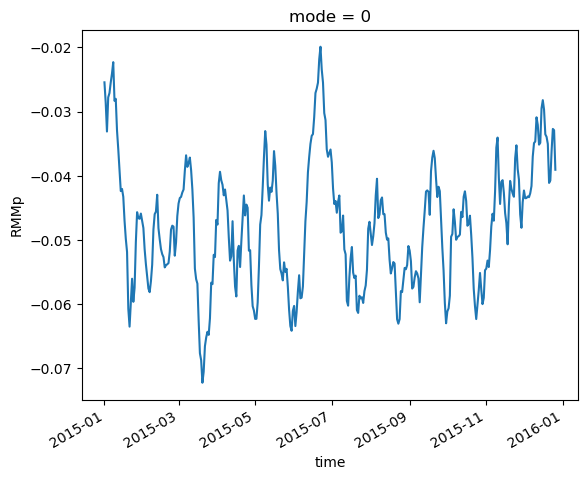

In [4]:
ds['RMMp'][:,0].plot()

In [2]:
fn = '/global/cfs/cdirs/m3312/whannah/2023-CPL/E3SM.INCITE2023-CPL.ne30pg2_EC30to60E2r2.WCYCL20TR-MMF1/data_remap_90x180/E3SM.INCITE2023-CPL.ne30pg2_EC30to60E2r2.WCYCL20TR-MMF1.eam.h1.2009-12-31-00000.remap_90x180.nc'
ds = xr.open_dataset(fn)
ds 

<xarray.Dataset>
Dimensions:              (lat: 90, lon: 180, nbnd: 2, time: 24, cosp_ht: 40,
                          cosp_htmisr: 16, cosp_prs: 7, cosp_reffice: 6,
                          cosp_reffliq: 6, cosp_scol: 10, cosp_sr: 15,
                          cosp_sza: 5, cosp_tau: 7, cosp_tau_modis: 7,
                          ilev: 61, lev: 60, lwband: 16, swband: 14)
Coordinates: (12/17)
  * lat                  (lat) float64 -89.0 -87.0 -85.0 ... 85.0 87.0 89.0
  * lon                  (lon) float64 1.0 3.0 5.0 7.0 ... 355.0 357.0 359.0
  * cosp_ht              (cosp_ht) float64 1.896e+04 1.848e+04 ... 720.0 240.0
  * cosp_htmisr          (cosp_htmisr) float64 0.0 250.0 ... 1.6e+04 1.8e+04
  * cosp_prs             (cosp_prs) float64 9e+04 7.4e+04 ... 2.45e+04 9e+03
  * cosp_reffice         (cosp_reffice) float64 5e-06 1.5e-05 ... 5e-05 7.5e-05
    ...                   ...
  * cosp_tau_modis       (cosp_tau_modis) float64 0.15 0.8 2.45 ... 41.5 100.0
  * ilev                 (ilev) float64 0.05588 0.1008 0.1814 ... 985.3 1e+03
  * lev                  (lev) float64 0.07835 0.1411 0.2529 ... 978.0 992.6
  * lwband               (lwband) float64 130.0 375.0 ... 2.535e+03 2.965e+03
  * swband               (swband) float64 2.925e+03 3.625e+03 ... 1.71e+03
  * time                 (time) object 2009-12-31 00:00:00 ... 2009-12-31 23:...
Dimensions without coordinates: nbnd
Data variables: (12/75)
    lat_bnds             (lat, nbnd) float64 ...
    lon_bnds             (lon, nbnd) float64 ...
    gw                   (lat) float64 ...
    area                 (lat, lon) float64 ...
    FLNS                 (time, lat, lon) float32 ...
    FLNT                 (time, lat, lon) float32 ...
    ...                   ...
    nsbase               int32 ...
    nscur                (time) int32 ...
    nsteph               (time) int32 ...
    sol_tsi              (time) float64 ...
    time_bnds            (time, nbnd) object ...
    time_written         (time) |S8 ...
Attributes: (12/26)
    ne:                        30
    fv_nphys:                  2
    title:                     EAM History file information
    source:                    E3SM Atmosphere Model
    source_id:                 d7b1001098
    product:                   model-output
    ...                        ...
    remap_hostname:            login20
    remap_version:             5.1.4
    NCO:                       netCDF Operators version 5.1.4 (Homepage = htt...
    nco_openmp_thread_number:  2
    map_file:                  /global/homes/w/whannah/maps/map_ne30pg2_to_90...
    input_file:                /global/cfs/cdirs/m3312/whannah/2023-CPL//E3SM...

In [1]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchinfo import summary
import numpy as np
import sys
# import netCDF4 as nc
# from saveNCfile import savenc
# from saveNCfile_for_activations import savenc_for_activations
from data_loader_loop import load_test_data
from data_loader_loop import load_train_data
# from prettytable import PrettyTable

# import hdf5storage
import pandas as pd 
import xarray as xr 
import dask 
import os 
from datetime import date 
from projection import projection

import matplotlib.pyplot as plt


2.0.0+cu117


In [2]:
fn = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/ERA5.sst.day.1900to2022.nc'

ds = xr.open_dataset(fn)

ds1 = ds.sel(time=slice('1979-01-01', '1979-01-02'), lat=slice(20, -20)).fillna(0)


In [5]:
x = ds1.isnull()
x.sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    sst      int64 0

In [ ]:
def load_train_data(vn,Fnmjo,leadmjo,mem_list,ysta,yend,zmode,m,mflg,wnx,wnxflg,lat_lim,mjo_ind,pic_save):
    # set parameters
    nmem = len(mem_list)  # memory length
    nmaps = len(vn)  # number of variables
    dimx = int(1 + 2 * int(lat_lim / 2))
    dimy = 180
    ndays = int( ( np.datetime64(str(yend)+'-01-01') - np.datetime64(str(ysta)+'-01-01') ) / np.timedelta64(1,'D') ) 

    # make projection and do zonal fft (time, lat, lon) one by one
    psi_train_input = np.zeros((ndays-mem_list[-1],nmem*nmaps,dimx,dimy))

    for i in np.arange(nmaps):
        # for each variable
        olr_re = projection(vn[i], zmode, m, mflg, wnx, wnxflg, [str(ysta)+'-01-01', str(yend-1)+'-12-31'], [lat_lim,-lat_lim],pic_save)
        # olr_re(time,lat,lon)
        
        # for each time step of a given variable
        for j in range(ndays-mem_list[-1]):
            psi_train_input[j, i*nmem:(i+1)*nmem, :, :] = olr_re[j:j+nmem, :, :]

        print('input shape inside the j loop: ', np.shape(psi_train_input[j, i*nmem:(i+1)*nmem, :, :]))
        print('olr_re shape inside the j loop: ', np.shape(olr_re[j:j+nmem, :, :]))

    # read the MJO index
    FFmjo = xr.open_dataset(Fnmjo)
    FFmjo = FFmjo.sel(time=slice(str(ysta)+'-01-01', str(yend)+'-03-31'))
    FFmjo.fillna(0)
    pc = np.asarray(FFmjo[mjo_ind])

    Nlat=dimx
    Nlon=dimy

    psi_train_label = pc[mem_list[-1]+leadmjo:mem_list[-1]+leadmjo+ndays-mem_list[-1],:]
    print('label shape is: ' + str(np.shape(psi_train_label)))

    psi_train_input_Tr=np.zeros([np.size(psi_train_input,0),nmem*nmaps,Nlat,Nlon])   # vn input maps
    psi_train_label_Tr=np.zeros([np.size(psi_train_label,0),2])  # 2 PC labels

    psi_train_input_Tr = psi_train_input
    psi_train_label_Tr = psi_train_label

    ## convert to torch tensor
    psi_train_input_Tr_torch = torch.from_numpy(psi_train_input_Tr).float()
    psi_train_label_Tr_torch = torch.from_numpy(psi_train_label_Tr).float()

    return psi_train_input_Tr_torch, psi_train_label_Tr_torch, ndays-mem_list[-1]


In [ ]:
vn = ['u200','u850','olr','tcwv','v200','T200','prep','u500','v500','v850','Z200','Z500','Z850','T500','T850','q200','q500','q850','sst']
# number of used variables
nmaps = len(vn)
Fnmjo = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/rmm/full/RMM_ERA5_daily_1901to2020.nc'
leadmjo = 1
nmem = 1
ysta = 1979
yend = 1980
zmode = 1
m = 1
mflg = 'off'
wnx = 1
wnxflg = 'off'
lat_lim = 20
mjo_ind = 'RMM'
pic_save = './test_output/'
mem_list = np.arange(nmem)
psi_train_input_Tr_torch, psi_train_label_Tr_torch, N = load_train_data(vn,Fnmjo,leadmjo,mem_list,ysta,yend,zmode,m,mflg,wnx,wnxflg,lat_lim,mjo_ind,pic_save)

In [5]:
psi_train_input_Tr_torch.shape

torch.Size([365, 19, 21, 180])

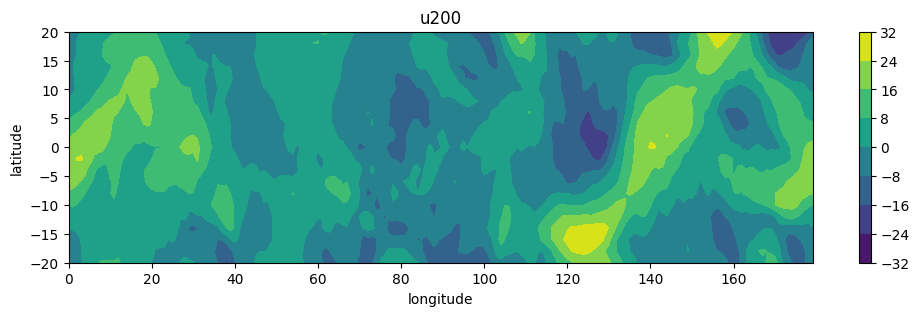

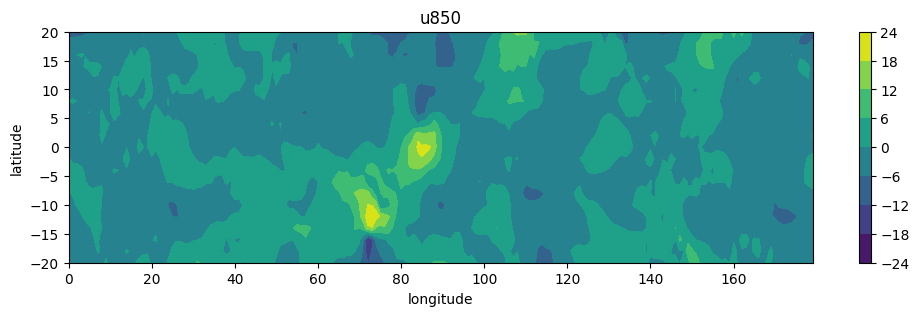

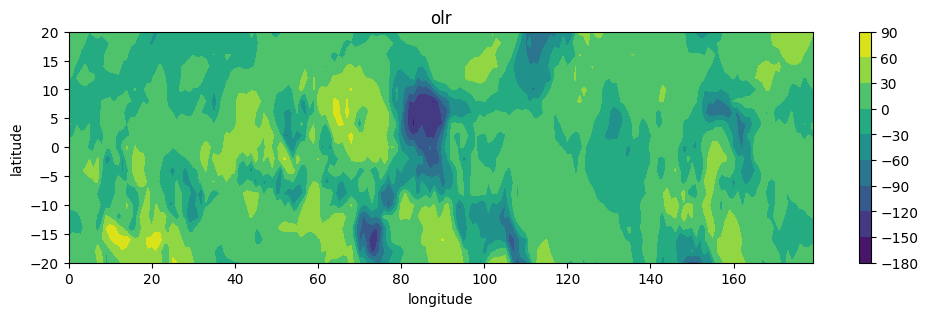

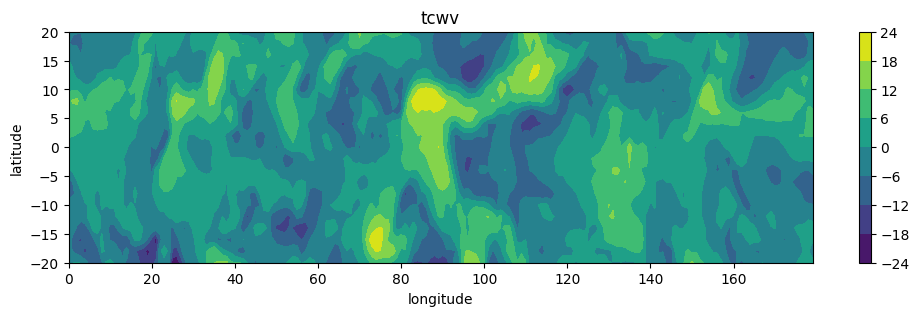

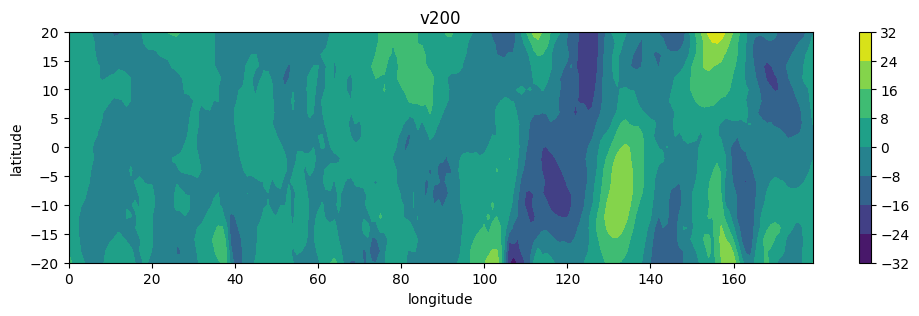

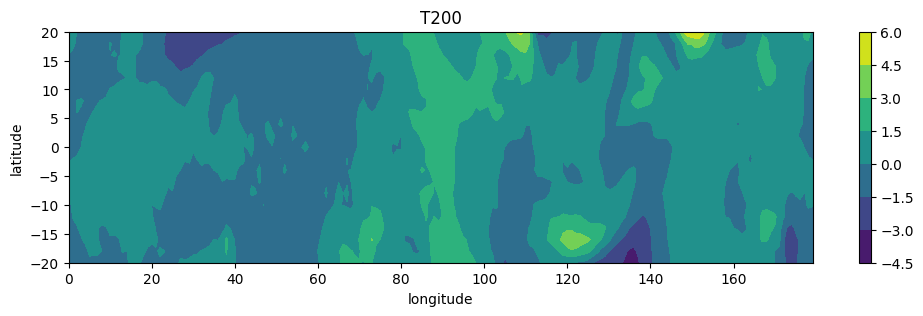

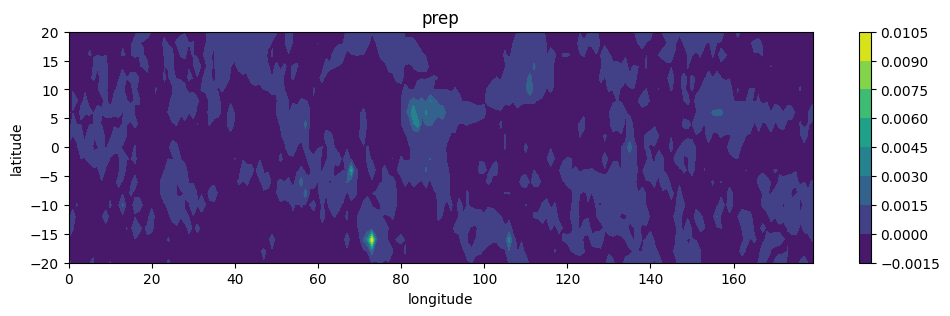

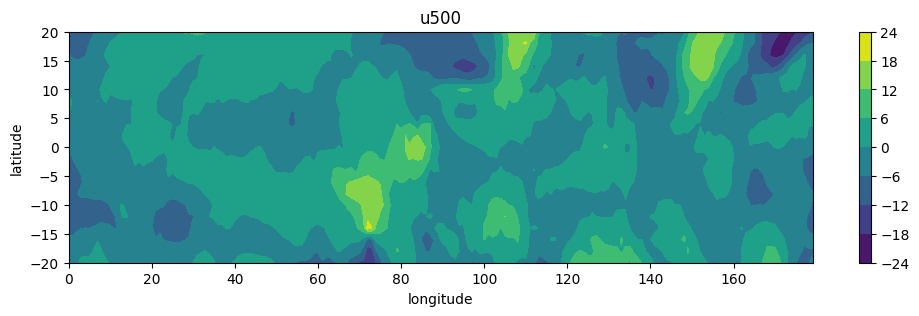

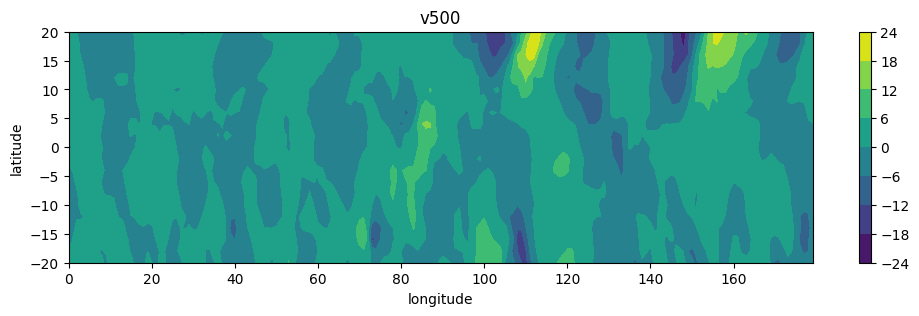

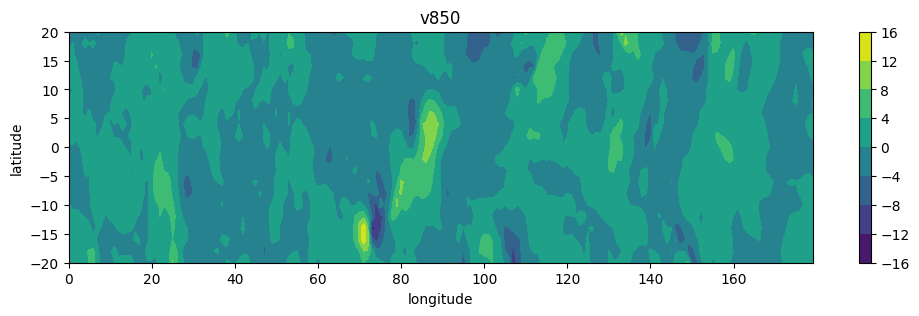

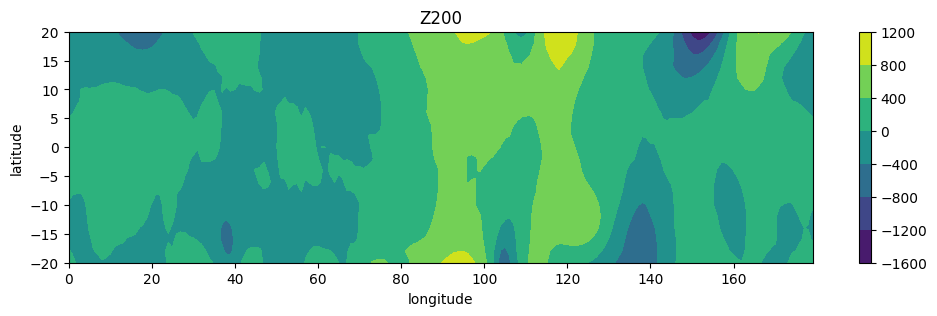

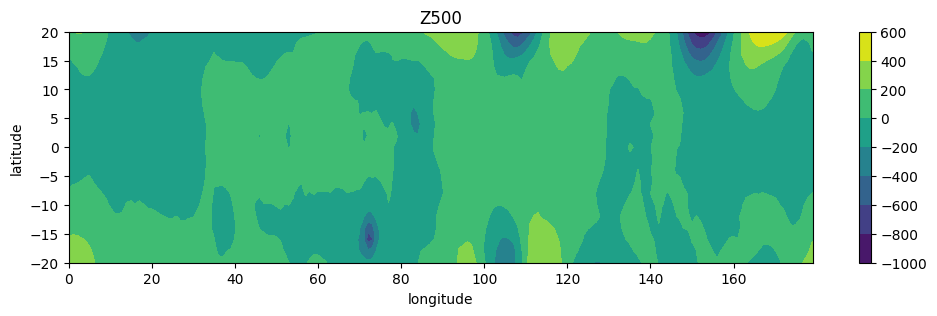

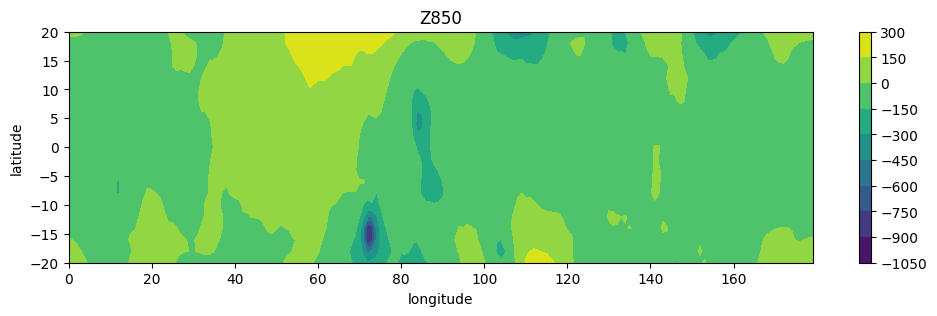

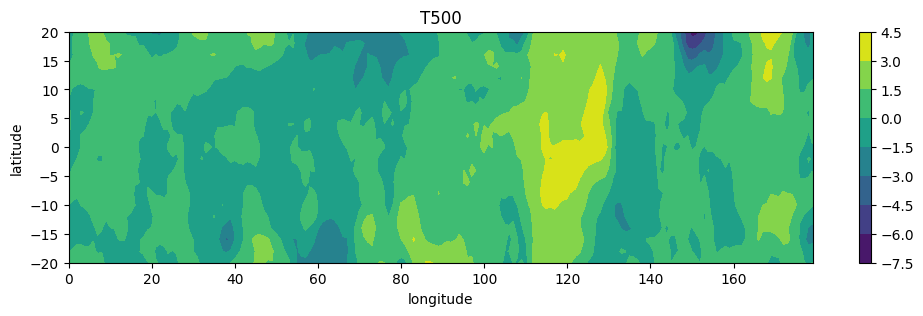

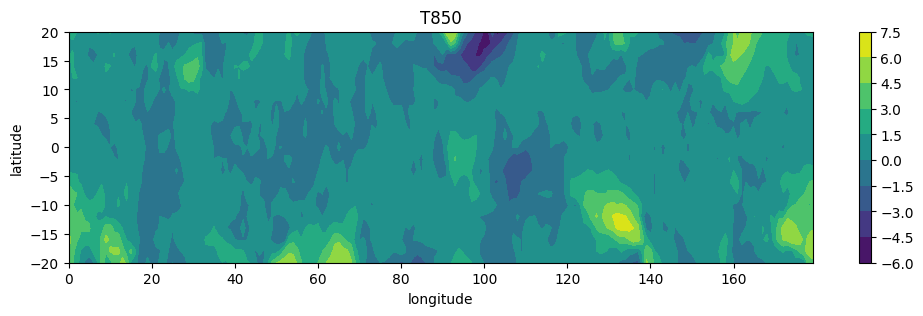

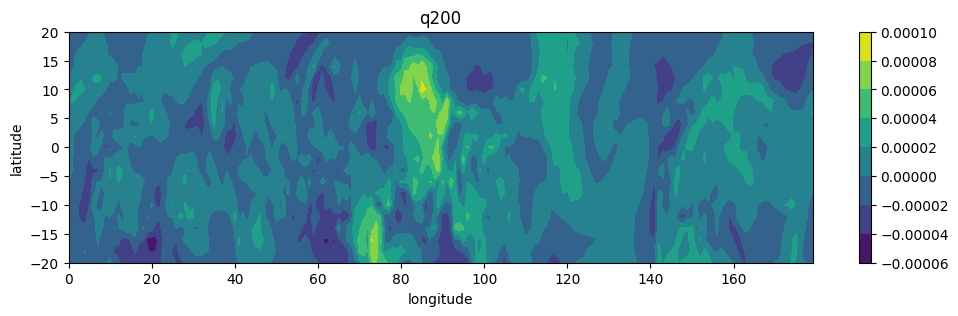

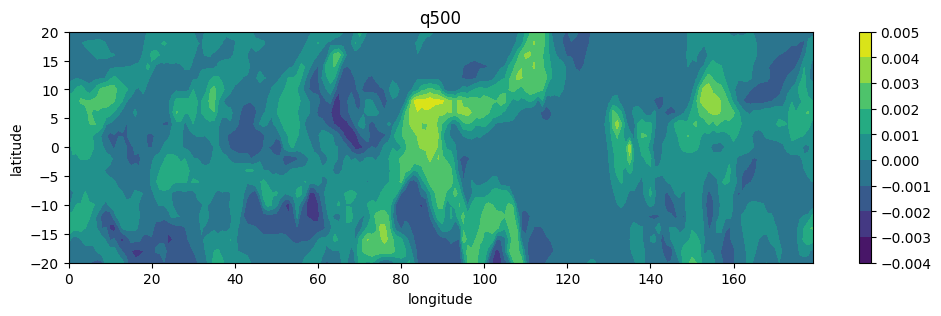

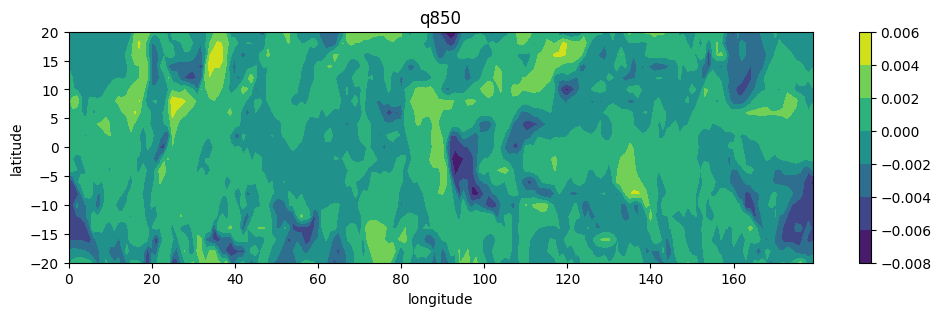

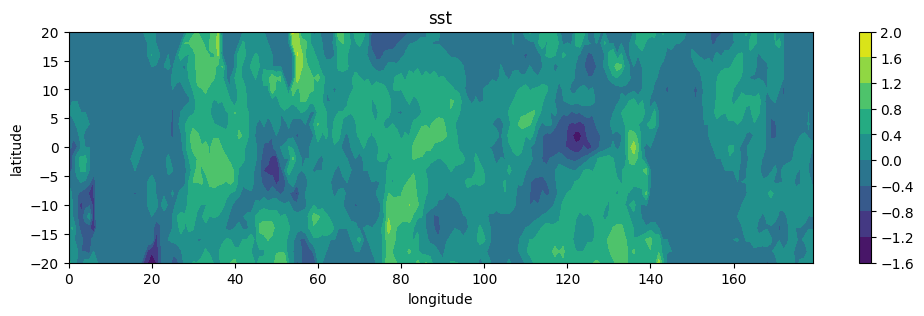

In [24]:
for i in np.arange(19):
    u200 = psi_train_input_Tr_torch[0,i].data.cpu().numpy()
    fig, ax = plt.subplots(1,1)
    fig.set_figheight(3)
    fig.set_figwidth(12)
    plt.contourf(np.arange(180), np.arange(20,-21,-2), u200)
    plt.colorbar()
    plt.title(vn[i])
    plt.xlabel('longitude')
    plt.ylabel('latitude')